In [102]:
print('Введите имя изображения:')
image_name = input()

Введите имя изображения


 IMG_1.jpg


In [103]:
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker
import numpy.random as rng
from skimage.feature import peak_local_max
from scipy import ndimage
import imutils
from skimage.exposure import histogram, equalize_hist, rescale_intensity
from skimage.exposure import adjust_sigmoid
from skimage.feature import canny
from skimage.morphology import dilation, erosion, closing, opening, binary_closing, binary_opening, convex_hull_image, disk, square
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation

In [104]:
def mask_r(img, th1=70, th2=170):
    h_min = np.array((th1, 0, 0), np.uint8)
    h_max = np.array((th2, 255, 255), np.uint8)
    cur_image = cv2.inRange(img, h_min, h_max)
    return cur_image

In [105]:
def mask_b(img, th1=0, th2=95):
    h_min = np.array((0, 0, th1), np.uint8)
    h_max = np.array((255, 255, th2), np.uint8)
    cur_image = cv2.inRange(img, h_min, h_max)
    return cur_image

In [106]:
def mask_g(img, th1=50, th2=120):
    h_min = np.array((0, th1, 0), np.uint8)
    h_max = np.array((255, th2, 255), np.uint8)
    cur_image = cv2.inRange(img, h_min, h_max)
    return cur_image

In [107]:
def mask_h(img, th1=100, th2=115):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_min = np.array((th1, 0, 0), np.uint8)
    h_max = np.array((th2, 255, 255), np.uint8)
    cur_image = cv2.inRange(hsv, h_min, h_max)
    return cur_image

In [108]:
def mask_s(img, th1=120, th2=255):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_min = np.array((0, th1, 0), np.uint8)
    h_max = np.array((255, th2, 255), np.uint8)
    cur_image = cv2.inRange(img, h_min, h_max)
    return cv2.bitwise_not(cur_image)

In [109]:
def mask_v(img, th1=5, th2=105):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_min = np.array((0, 0, th1), np.uint8)
    h_max = np.array((255, 255, th2), np.uint8)
    cur_image = cv2.inRange(img, h_min, h_max)
    return cur_image

In [9]:
def mask_bh(img):
    b = mask_b(img)
    h = mask_h(img)
    cur_image = cv2.bitwise_and(b, b, mask=h)
    return cur_image

In [110]:
def mask_bhr(img):
    r = mask_r(img)
    bh = mask_bh(img)
    cur_image = cv2.bitwise_and(bh, bh, mask=r)
    return cur_image

In [111]:
def mask_bhrs(img):
    s = mask_s(img)
    bhr = mask_bhr(img)
    cur_image = cv2.bitwise_and(bhr, bhr, mask=s)
    return cur_image

In [112]:
def fill_cards(edges):
    new_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8))
    contours, image = cv2.findContours(image = new_edges, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(new_edges, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    new_edges = cv2.morphologyEx(new_edges, cv2.MORPH_OPEN, np.ones((5,5), np.uint8)) #10, 10
    new_edges = cv2.erode(new_edges, np.ones((3,3), np.uint8), iterations=1) # 12, 12
    return new_edges

In [113]:
def show_images(img_arr, columns=1, img_names=None, save=False, save_name=None):
    rows = len(img_arr) // columns
    if rows > columns:
        fig = plt.figure(figsize=(4 * rows, 7 * rows))
    else:
        fig = plt.figure(figsize=(7 * columns, 10 * columns))
    for i in range(len(img_arr)):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img_arr[i], cmap='gray')
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='both', labelsize=11)
        if img_names is not None:
            ax.set_title(img_names[i], fontsize=11)
    plt.tight_layout()
    if save:
        plt.savefig(save_name, bbox_inches="tight")
    plt.show()

In [114]:
def find_figures(image_name, mask, image=None, filter_type=None, show=True):
    if image is None:
        img = cv2.imread(image_name) # open image
    else:
        img = image
    start_img = img.copy()
    if show:
        cv2.imshow(image_name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    if filter_type == 'median': # filters
        img = cv2.medianBlur(img, 3)
    elif filter_type == 'bilateral':
        img = cv2.bilateralFilter(img, d=2, sigmaSpace=300, sigmaColor=25)
    elif filter_type == 'sum':
        img = cv2.bilateralFilter(img, d=2, sigmaSpace=300, sigmaColor=25)
        img = cv2.medianBlur(img, 3)
    if show:
        cv2.imshow('After filters', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    mask_color = mask(start_img) # find 1-st mask
    if show:
        cv2.imshow('1 mask', mask_color)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Canny operator - 2-nd mask
    edges = cv2.Canny(image=gray, threshold1=30, threshold2=80)
    if show:
        cv2.imshow('canny', edges)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    white_cards = fill_cards(edges) # fill cards
    if show:
        cv2.imshow('white cards', white_cards)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    mask0 = cv2.bitwise_and(mask_color, mask_color, mask=edges) # find mask
    if show:
        cv2.imshow('final mask', mask0)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    # morphological transformations
    result = cv2.bitwise_and(white_cards, white_cards, mask=mask0)
    if show:
        cv2.imshow('After mask', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    result = cv2.dilate(result, np.ones((3,3), np.uint8), iterations=1)
    if show:
        cv2.imshow('After dilate', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, np.ones((4,4), np.uint8), iterations=1)
    if show:
        cv2.imshow('After closing', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    contours, image = cv2.findContours(image = result, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(result, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    if show:
        cv2.imshow('After filling', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    kernel = np.array([[0, 0, 1, 0, 0], 
                       [0, 0, 1, 0, 0], 
                       [1, 1, 1, 1, 1],
                       [0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0]], np.uint8)
    result = cv2.erode(result, kernel, iterations=2)
    result = cv2.erode(result, np.ones((3,3), np.uint8), iterations=2)
    if show:
        cv2.imshow('After erode', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return result

In [115]:
def smooth(cnt):
    length = cv2.arcLength(cnt, True)
    epsilon = length / 50
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    angles1 = len(approx)
    epsilon = length / 70
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    angles2 = len(approx)
    if abs(angles2 - angles1) >= 2:
        return True
    return False

In [116]:
def smooth_c(cnt):
    length = cv2.arcLength(cnt, True)
    epsilon = length / 50
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    angles1 = len(approx)
    epsilon = length / (15 * angles1)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    angles2 = len(approx)
    if angles2 - angles1 >= 3:
        return True
    return False

In [117]:
def detect(image_name, image=None):
    if image is None:
        fig = find_figures(image_name, mask=mask_h, filter_type='sum', show=False)
    else:
        fig = find_figures(image_name, image=image, mask=mask_h, filter_type='sum', show=False)
    contours, image = cv2.findContours(image = fig, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
    img_copy = cv2.imread(image_name)
    n_cards = 0
    for cnt in contours:
        area = cv2.contourArea(cnt) # вычисление площади
        #print(area)
        if area > 350:
            #print(area)
            cv2.drawContours(img_copy,[cnt],0,(255,0,0),2) # рисуем прямоугольник
            n_cards += 1
            
            #определяем выпуклость
            hull = cnt.copy()
            ch = cv2.convexHull (cnt, hull, True, True)
            h_area = cv2.contourArea(ch)
            #print("     h_area =", h_area)
            if abs(area - h_area) < 200:
                if smooth_c(cnt):
                    continue
                cur_h = 0
                cur_w = 0
                for c in ch:
                    if c[0][0] > cur_h:
                        cur_h = c[0][0]
                    if c[0][1]> cur_w:
                        cur_w = c[0][1]
                length = cv2.arcLength(cnt, True)
                epsilon = length / 50
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                cv2.drawContours(img_copy, approx, -1, (0, 255, 0), 3)
                img_copy = cv2.putText(img_copy, 'P'+str(len(approx))+'C', (cur_h, cur_w), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
            else:
                if smooth(cnt):
                    continue
                cur_h = 0
                cur_w = 0
                for c in ch:
                    if c[0][0] > cur_h:
                        cur_h = c[0][0]
                    if c[0][1]> cur_w:
                        cur_w = c[0][1]
                length = cv2.arcLength(cnt, True)
                epsilon = length / 50
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                cv2.drawContours(img_copy, approx, -1, (0, 255, 0), 3)
                img_copy = cv2.putText(img_copy, 'P'+ str(len(approx)), (cur_h, cur_w), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
    text = str(n_cards)
    img_copy = cv2.putText(img_copy, text+' cards', (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.imshow('result', img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return img_copy

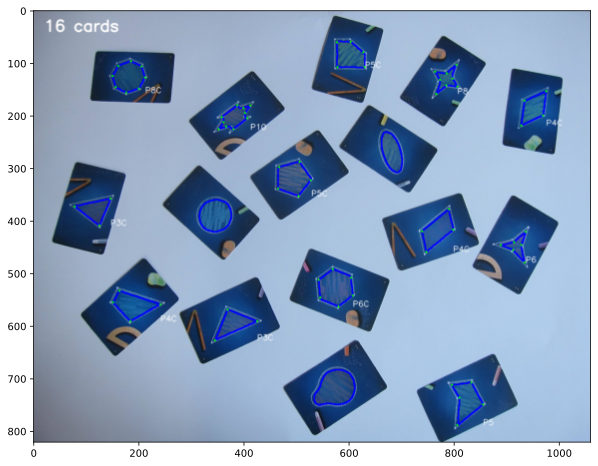

In [119]:
result = detect(image_name)
fig = plt.figure(figsize=(10,9))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGBA))
plt.savefig('result', bbox_inches="tight")
plt.show()